In [26]:
#Import necessary modules

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek


In [27]:
#Load cleaned dataset
ppi_clean=pd.read_csv("data_clean.csv")
ppi_clean

,domain,aa_ProtPosition,uniprot_id,hydrophobicity_scores,Rlength,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,prob_sheet,...,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface,hydrophobicity_scores.1
0,0,1,A0A024RAV5,0.64,188,0.238095,0.784319,0.711111,0.803,0.003,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0,0.64
1,0,2,A0A024RAV5,-0.05,188,0.238095,0.359207,0.422222,0.530,0.047,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0,-0.05
2,0,3,A0A024RAV5,-0.74,188,0.238095,0.395387,0.111111,0.464,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0,-0.74
3,0,4,A0A024RAV5,0.26,188,0.238095,0.401655,0.355556,0.385,0.084,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0,0.26
4,1,5,A0A024RAV5,-1.50,188,0.238095,0.288103,0.066667,0.287,0.084,...,0.436017,0.238759,0.103980,0.105653,0.161544,0.060391,0.140326,0.481904,0,-1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65145,1,34,P0A427,1.38,38,0.014881,0.210794,1.000000,0.233,0.086,...,0.374128,0.415754,0.109332,0.351726,0.330383,0.241807,0.334863,0.381730,1,1.38
65146,0,35,P0A427,-0.74,38,0.014881,0.292872,0.111111,0.343,0.086,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1,-0.74
65147,0,36,P0A427,0.48,38,0.014881,0.141193,0.455556,0.367,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1,0.48
65148,0,37,P0A427,-0.74,38,0.014881,0.406473,0.111111,0.477,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1,-0.74


Text(0.5, 1.0, 'Class Distribution of the ppi dataset')

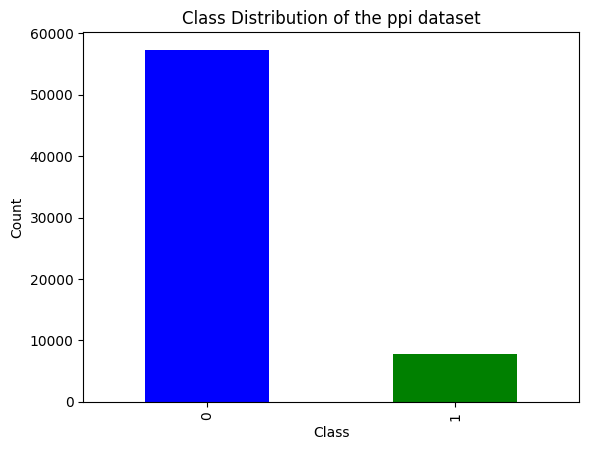

In [28]:
#Check for class distribution

class_counts=ppi_clean["p_interface"].value_counts()
class_counts.plot(kind="bar",color=["blue","green"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution of the ppi dataset")


In [29]:
#Load train data
train_data = pd.read_csv("ppi_clean_train.csv")
train_data

,domain,aa_ProtPosition,uniprot_id,hydrophobicity_scores,Rlength,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,prob_sheet,...,9_wm_pssm_K,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface
0,0,1,Q503K9,0.64,99,0.105655,0.762537,0.711111,0.781,0.003,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
1,0,2,Q503K9,0.12,99,0.105655,0.228813,0.322222,0.330,0.017,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
2,0,3,Q503K9,-0.18,99,0.105655,0.291686,0.411111,0.510,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
3,0,4,Q503K9,-1.50,99,0.105655,0.374165,0.066667,0.373,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
4,1,5,Q503K9,1.06,99,0.105655,0.254662,0.922222,0.285,0.043,...,0.236424,0.385451,0.040772,0.237208,0.386928,0.315001,0.060391,0.039517,0.197994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52022,1,34,P0A427,1.38,38,0.014881,0.210794,1.000000,0.233,0.086,...,0.286923,0.374128,0.415754,0.109332,0.351726,0.330383,0.241807,0.334863,0.381730,1
52023,0,35,P0A427,-0.74,38,0.014881,0.292872,0.111111,0.343,0.086,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
52024,0,36,P0A427,0.48,38,0.014881,0.141193,0.455556,0.367,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
52025,0,37,P0A427,-0.74,38,0.014881,0.406473,0.111111,0.477,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1


In [30]:
#Remove unnecessary features
def remove_non_features(df: pd.DataFrame, non_feature_cols: list[str]) -> pd.DataFrame:
    return df.drop(non_feature_cols, axis=1)

In [31]:
#Split train/validation and test sets based on UNIPROT IDS
from sklearn.model_selection import GroupShuffleSplit

def split_data_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, **kwargs) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    gss = GroupShuffleSplit(**kwargs)

    for train_idx, test_idx in gss.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    assert set(X_train.uniprot_id).intersection(set(X_test.uniprot_id)) == set(), 'The same uniprot ID appears in both the train and test set!'
    return X_train, X_test, y_train, y_test

X_tv = train_data.drop('p_interface', axis=1)
y_tv = train_data.p_interface
groups = train_data.uniprot_id

In [ ]:
#Run different resampling techniques without any hyperparamter tuning
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, recall_score, precision_score


def kfold_cv_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, model: BaseEstimator, param_grid: dict, **kwargs):
    group_kfold = GroupKFold(**kwargs)

    scores = {'fold': [], 'auc': [], 'rec': [], 'pre': []}
    fold_data = {'Fold': [], 'Set': [], 'Size': []}

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
        print(f'Performing on {fold=}')
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        resampling_methods = {
        "Original": None,
        "SMOTE": SMOTE(sampling_strategy='auto', random_state=42),
        "Random Under": RandomUnderSampler(random_state=42),
        "ADASYN": ADASYN(sampling_strategy='auto', random_state=42),
        "SMOTE-Tomek": SMOTETomek(random_state=42)}


        def sampling_method(X_resampled, y_resampled, method_name):
            grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_resampled, y_resampled)

            # Best model from grid search
            best_model = grid_search.best_estimator_

            # Use the best model for evaluation
            y_pred_labels = best_model.predict(X_val)
            y_pred_proba = best_model.predict_proba(X_val)[:, 1]
            auc_score = roc_auc_score(y_val, y_pred_proba)
            class_report = classification_report(y_val, y_pred_labels, output_dict=True)


        # Store metrics
            scores['fold'].append(fold)
            scores['auc'].append(auc_score)
            scores['rec'].append(class_report['1']['recall'])  # TPR for class 1
            scores['pre'].append(class_report['1']['precision'])  # Precision for class 1

            fold_data['Fold'].extend([fold, fold, fold, fold])  # Add fold index twice
            fold_data['Set'].extend(['Train_P', 'Train_N', 'Test_P', 'Test_N'])  # Train and Test labels
            fold_data['Size'].extend([len(y_train[y_train == 1]), len(y_train[y_train == 0]),
                                  len(y_val[y_val == 1]), len(y_val[y_val == 0])])  # Number of samples
            print(f"Fold {fold} AUC: {auc_score:.4f}")
            print(f"Classification Report for Fold {fold}:\n", classification_report(y_val, y_pred_labels))

        for method_name, resampler in resampling_methods.items():
            print(f"Applying {method_name} resampling for Fold {fold}...")
            if resampler is None:
                sampling_method(X_train, y_train, method_name)
            else:
                X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
                sampling_method(X_resampled, y_resampled, method_name)



    # Convert to DataFrame
    fold_df = pd.DataFrame(fold_data)
    results[method_name] = pd.DataFrame(scores)
    return results[method_name]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

non_feature_cols = ['domain', 'aa_ProtPosition', 'uniprot_id']
X = remove_non_features(X_tv, non_feature_cols)
y = y_tv
groups = X_tv.uniprot_id
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
model_scores = kfold_cv_by_group(X, y, groups, rf_model, param_grid, n_splits=5)


Performing on fold=0
Applying Original resampling for Fold 0...


In [ ]:
#Evaluation on test set
#Yet to be updated

In [ ]:
#Plot AUC Scores across folds for each resampling method
#Yet to be updated for each method
plt.figure(figsize=(8,5))
plt.plot(scores_df['fold'], scores_df['auc'], marker='o', linestyle='-', label="AUC Score")
plt.axhline(y=scores_df['auc'].mean(), color='r', linestyle='--', label="Mean AUC")
plt.xlabel("Fold")
plt.ylabel("AUC Score")
plt.title("AUC Score Across Folds for SMOTE")
plt.legend()
plt.show()

In [ ]:
#Distribution in each of the oversampled or undersampled train sets